<a href="https://colab.research.google.com/github/skmda37/StyleTransfer/blob/master/tensorflowStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**My Grilfriend's Tiger painted as Franz Marc's TIGER**


Welcome to my style transfer colab. Here we are going to implement the ideas from the 2015 paper ["A Neural Algorithm of Artistic Style"](https://arxiv.org/abs/1508.06576) by *Leon A. Gatys, Alexander S. Ecker, Matthias Bethge*, and paint my girlfriend's dog "Tiger" as the artist Franz Marc might have done. Below is a picture of "Tiger" (Shih Tzu).

<figure>
<center>
<img src='https://drive.google.com/uc?id=1DaDURnkGYfJ2D8eoXrjg-84dXffBcX1z' />
<figcaption>Dog "Tiger"</figcaption></center>
</figure>

We will try to paint "Tiger" like the painting below of a TIGER by [`Franz Marc`](https://en.wikipedia.org/wiki/Franz_Marc). If you happen to own a horse you might want to try his [`Blue Horse`](https://www.wikiart.org/en/franz-marc/blue-horse-i-1911) painting.

![TIGER by Franz MArc](https://drive.google.com/uc?id=1S6cVG_neSru21cEGY7UoN1XQy-trfaIH)

You will probably want to play around with your own choice of image and painting. I will therefore highlight the cells of code where you can change e.g. a path or directory that will allow you to do so.

Let's get started. First of all you have to decide if you are going to use a GPU or not. I tried to implement the Style transfer without a GPU and it took very long (maybe around 6 seconds per gradient step, 1000 total steps, that would take 100 min to train which we can avoid). In case you don't use a GPU it is useful to save your image tensor after an epoch so that you don't loose your progress in case the colab disconnects. We will do this but run the notebook in a GPU.

We will start importing the important modules.

In [0]:
import tensorflow as tf
import os

In [0]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image 
import time
import functools

My pictures are in my google drive. The code below allows us to access the drive folder. Don't forget to authenticate your drive by clicking the link below after runnning the cell for the first time.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Our first function will simply allow us to convert a tensor to an image that we can display in the notebook.

In [0]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

You might want to implement **your own style transfer** so feel free to **change the content** and style paths below to an image and painting of your choice. Note that you will get an unexpected result if you confuse style with content image so make sure you get it right unless you would like to see what Franz Marc's Tiger looks like painted in the style of the photograph of Shi Tzu Tiger!

In [0]:
content_path = "drive/My Drive/style_transfer_project/images/tigerHarlem.JPG"
style_path = "drive/My Drive/style_transfer_project/images/tigerFranzMarc.png"

We want to feed our images into a neural network. This neural network receives as input a tensor in a certain shape. Therefore we have to laod the image from its path and convert it to a tensor of the desired shape. The function below does exactly that.

In [0]:
def load_img(path_to_img):
  max_dim = 512
  #load image
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  #get new shape 
  new_shape = tf.cast(shape * scale, tf.int32)
  #resize image tensor to new shape
  img = tf.image.resize(img, new_shape)
  #add "redundant" axis for neural network later
  img = img[tf.newaxis, :]
  return img

It will be convenient to display the image. Therefore we define a function that takes the tensor of an image and display it using th eprevious function `imshow()`.

In [0]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    #get rid of redundant axis to display image later
    image = tf.squeeze(image, axis=0)
  #display image
  plt.imshow(image)
  if title:
    #plot title
    plt.title(title)

Let's plot the style and content image next to each other.

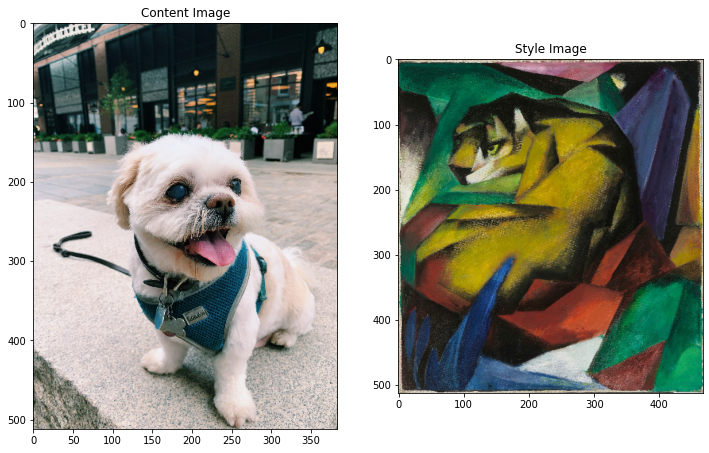

In [8]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image,'Content Image')

plt.subplot(1,2,2)
imshow(style_image, 'Style Image')


This is a good point to sketch out the algorithm for the neural style transfer. We will take a powerful image classification neural network (in our case `vgg19`) which was trained to classify images form imagenet into 1000 categories and pick out several intermediate layers. These intermediate layers are capable of finding all kinds of representatnive features in an image like edges colors and certain shapes. We will fix a set of layers (`style layers`) to code information about the style of our image and one layer (`content layer`) for the content of the image. Then we will train our content image with gradient descent to minimize a loss function that will roughly enforce our image to have similar style (not in L2 but similar correlation of features, see later for the specifics) layer activations as our style image and close content layer activations to our content image (close in the sense of L2 distance).

The cell below preprocesses our content image for the vgg19 network and loads the vgg19 with weights trained on imagenet.

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224,224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

We can check for fun what vgg19 believes Tiger is. Note me and my girlfriend believe he is a Shi Tzu! The list below contains the top 5 probablilities vgg19 assigned to the labels for Tiger.

In [10]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Pekinese', 0.89584494),
 ('Shih-Tzu', 0.042799592),
 ('pug', 0.02515432),
 ('Lhasa', 0.016690856),
 ('French_bulldog', 0.0030330226)]

Wait what..? Vgg19 is very confident that he is a "Pekinese" and not a "Shih-Tzu"?! Anyways this is not the topic of this notebook. Let's continue setting up the style transfer!

We will only need intermediate layers of vgg19. Thus we will set `include_top=False`. Let's also print the layers of vgg19 that we loaded. As expected the powerful imageclassifier has many convolutinal layers.

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Here we will define the set of style and content layers. You can take different ones and experiment. It doesn't make a lot of sense to take more than one content layer since we will maximize the L2 distance of the activation our style transfer image and the actual content image activations and more layers would be redundant. For style it will be different becasue we are not interested in having similiar style layer activations but rather correlation of features detected in the style layers. This allows us to keep the content and trasfer the style in a flexible manner. We are not intedersted in keeping the contentn of the style image.

In [0]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers =len(content_layers)
num_style_layers = len(style_layers)

Next we define a function that takes as inputs a list of vgg19 layer names and returns a model that outputs the activations of the specified layers.

In [0]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

It's useful to be aware of the shapes of the output of the layers we will work with. The code below will print the shape of each style layer.

In [14]:
#get output of activations in style layers of style_image
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#print shape for each style layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print()

block1_conv1
  shape:  (1, 512, 467, 64)

block2_conv1
  shape:  (1, 256, 233, 128)

block3_conv1
  shape:  (1, 128, 116, 256)

block4_conv1
  shape:  (1, 64, 58, 512)

block5_conv1
  shape:  (1, 32, 29, 512)



Next we have to talk about how we will optimize for the style to be transferred from the painting to the photograph. We will optimize the activations of our content image to be "similar" to a `style_target` and `content_target`.


> The `content_target` will simply be the activations of our content image in the `content_layer` (`"block5_conv2"`).


> The `style_target` will be a gram matrix of correlations between the feature maps in the corresponging `style_layers` of the style image, i.e our painting.

`About the Gram Matrix:` The intuition is that we are not interested in where exactly style features appear but rather how different style features are combined. The gram matrix may encode that. Let's define the gram matrix for a convolutinal layer $l$ (e.g. `"block4_conv1"`). The convolutial layer $l$ consists of feature maps $\{F_c: c\}$ and each feature map can be indexed by its spatial dimensions $i,j$ through $F_{ijc}$. The spatial dimensions will be denoted as $I$ and $J$ respectively. Mathematically, the gram matrix at layer $l$ is merely a matrix denoted as $G^l$ with indices
$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}.$$




The cell below is a function that takes as input a tensor (e.g. covolutional layer $l$) and returns the gram matrix $G^l$. Fortunately there is a function `tf.linalg.einsum`in tensorflow that does all the computations for us.

In [0]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

Next we will define our model class `StyleContentModel`. It can be initialized by feeding it a set of `style_layers` and `content_layers`. Once the model is initialized it can be called by giving it an `input` (tensor of an image) and it returns a dictionary `{'content': content_dict, 'style':style_dict}` where
`content_dict` and `style_dict` are dictionaries with `layer_name` as key and value as output of the `input`  at the specified layer.

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
  
  def call(self,inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name:value
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}
    
    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style':style_dict}


Next we initialize a `StyleContentModel` as `extractor` because the model extracts style and content values of an image. Then we will call the extractor on the `content_image` and print the shape of the style activations (`Gram Matrix` for every `style_layer`). 

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("   shape: ", output.numpy().shape)
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("   shape: ", output.numpy().shape)
  print()



Styles:
   block1_conv1
   shape:  (1, 64, 64)

   block2_conv1
   shape:  (1, 128, 128)

   block3_conv1
   shape:  (1, 256, 256)

   block4_conv1
   shape:  (1, 512, 512)

   block5_conv1
   shape:  (1, 512, 512)

Contents:
   block5_conv2
   shape:  (1, 32, 24, 512)



We set the `style_targets` as the `gram matrices` for the `style_image` at the style_layers and the `content_targets` as the `activations` for the `content_image` at the content_layers.

In [0]:
# set targets for loss function
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Since the tensor value of our image will be scaled to be between 0 and 1, we have to make sure that the values remain between 0 and 1 after a training step. For this we define the function `clip_0_1`.

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0,clip_value_max=1.0)

Next we initialize the adam optimizer. The parameters are the same as the  one's used in the [original tensorflow tutorial on style transfer](https://www.tensorflow.org/tutorials/generative/style_transfer)

In [0]:
# initialize optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Next we set the `style_weight` and `content_weight` for the loss function. You may have to play around with these later to get a satisfying style transfer. In my case I will start with  the following weights. We will later see if we have "enough style" adopted or lost "too much content" of the original image. The higher the style_weight the more the image will adopt the style and loose its content. You have to find a good balance.

In [0]:
# set weights for style and content in lossfunction
style_weight=1e4
content_weight=1e4

Now we will define the loss function. The loss function takes as input `outputs` of the style and content values of our image and returns the weighted `l2` distance between `style_outputs` of the image and `style_targets` (i.e. gram matrices) and weighted `l2` distance between `content_outputs` of the image and `content_targets`.

In [0]:
def style_content_loss(outputs,content_weight=content_weight,
                       style_weight=style_weight):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                        for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                          for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return loss

We create a tensorflow variable `image` which stores the tensor values of our content image. On this variable we will be perform gradient descent so that the image adopts the desired style and retains its content.

In [0]:
image = tf.Variable(content_image)

We now extract the style and content output from the image. Recall that we can  acces them by the name of the layer.

In [24]:
output = extractor(image)
print(output['style'].keys(),output['content'].keys())


dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']) dict_keys(['block5_conv2'])


If you now simply run gradient descent on our image with resepct to loss function defined in `style_content_loss` we will get a style_transfer with high frequency patterns that we didn't ask for. High frequency patterns are just big differences in pixel values among nearby pixels. It doesn't look nice. Thus we will incorportate one more thing into the loss function, namely `total_variation` of our image which measures exactly the high frequencies by calculating the difference of pixel values of adjacent values (adjacent in the x-direction and also in the y_direction). Higher `total_variation` results in higher frequency patterns thus we will add it to the loss function with a certain `total_variation_weight`.

In [0]:
total_variation_weight = 30

Here comes the training step where we pump the image throught the vgg19 and extract the style and content values in the specified layers and calculate its loss. While doing so we keep track of the gradient by using `with tf.GradientTape() as tape:`. Then we get the gradient of the loss with respect to the image tensor and perform a gradient descent according to our optimizer `opt`. After the gradient descent step we clip the overflowing pixel vlaues at 0 and 1 with `clip_0_1`.

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

I mentioned earlier that if you don't run the training on a GPU you want to save checkpoints. If you run on a GPU in colab you can just skip the code cell below and leave it uncommented. For the people without a GPU I suggest uncommenting the code below. There we will initialize the `checkpoint_directory` where I want to save my checkpoint files. Basically the `checkpoint` object  below will keep track of the values in our image and the optimizer during training and with the checkpoint `manager` we can restore and save the values in case the notebook disconnects during training.

In [27]:
# initialize checkpoint manager
#uncomment if you are not using a GPU
"""
checkpoint_directory = "drive/My Drive/style_transfer_project/checkpoint_tiger"

checkpoint = tf.train.Checkpoint(optimizer=opt, variable=image)
manager = tf.train.CheckpointManager(checkpoint=checkpoint,directory=checkpoint_directory,max_to_keep=3)
"""

'\ncheckpoint_directory = "drive/My Drive/style_transfer_project/checkpoint_tiger"\n\ncheckpoint = tf.train.Checkpoint(optimizer=opt, variable=image)\nmanager = tf.train.CheckpointManager(checkpoint=checkpoint,directory=checkpoint_directory,max_to_keep=3)\n'

Finally we define the function that will perform the style trasnfer. You can feed it an image, a manager for the checkpoints (if you are using a GPU don't) and the number of epochs you want to train the image for. **I strongly suggest that if you will use a GPU and want to play around with different images that you don't use my checkpoint manager and leave it uncomments otherwise you might reload a checkpoint from a differen style tranfer problem and run into issues.**

In [0]:
def train(image, epochs, manager=None):
  #keep checkpoint code uncommented if run on a GPU
  """
  checkpoint.restore(manager.latest_checkpoint)
  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")
  """
  steps = 100
  for n in range(epochs):
    print("Epoch: {} | ".format(n), end="")
    for step in range(steps):
      print("=", end="")
      #perform training step
      train_step(image)
    
    #display updated image
    display.display(tensor_to_image(image))
    """
    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(n+1,save_path))
    """
  
  #plot original images for comparison
  plt.subplot(1,2,1)
  imshow(content_image,'Content Image')
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.axis('off')
  imshow(style_image, 'Style Image')


I will run a total of `10 epochs` with `100 gradient steps per epoch`. For every epoch I will display the image to see the progress.

Epoch: 0 | ====================================================================================================

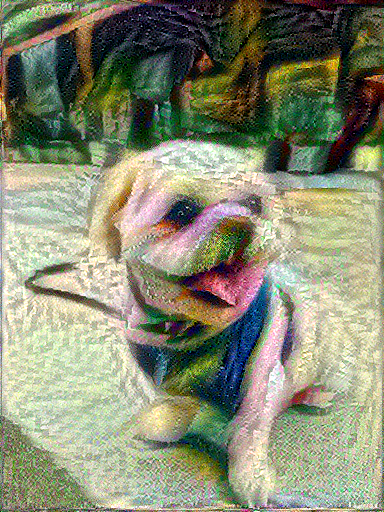

Epoch: 1 | ====================================================================================================

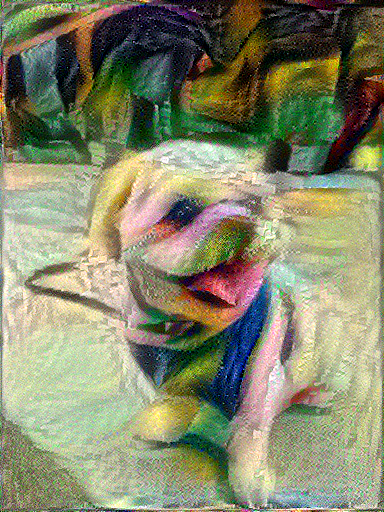

Epoch: 2 | ====================================================================================================

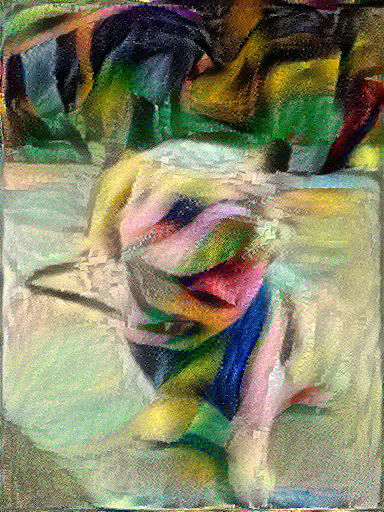

Epoch: 3 | ====================================================================================================

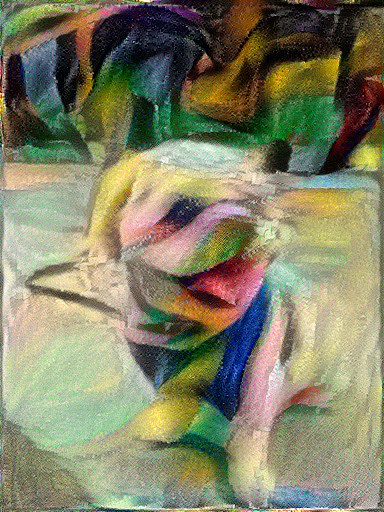

Epoch: 4 | ====================================================================================================

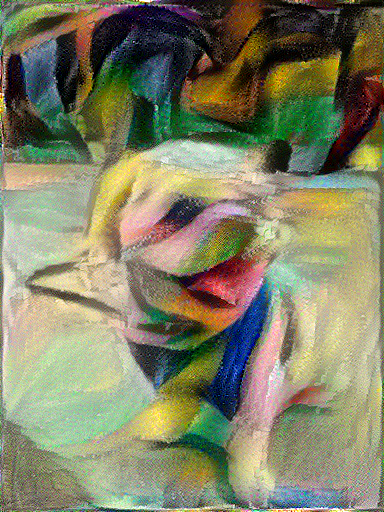

Epoch: 5 | ====================================================================================================

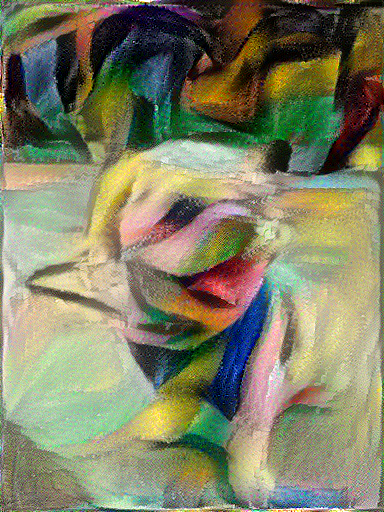

Epoch: 6 | ====================================================================================================

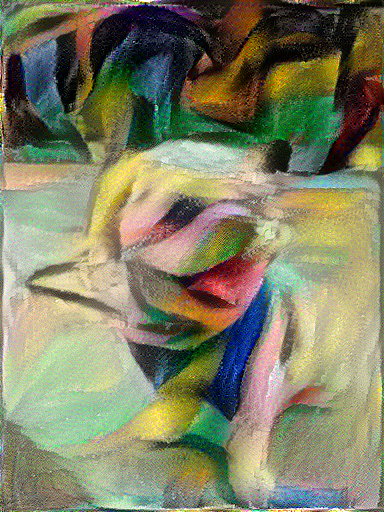

Epoch: 7 | ====================================================================================================

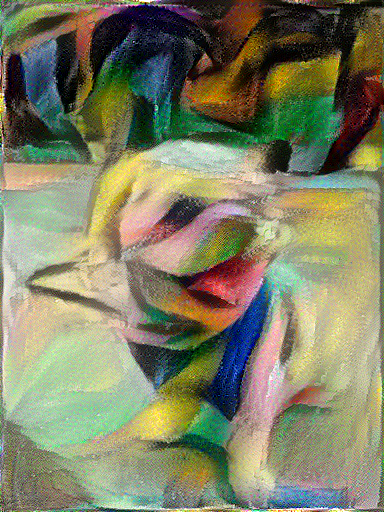

Epoch: 8 | ====================================================================================================

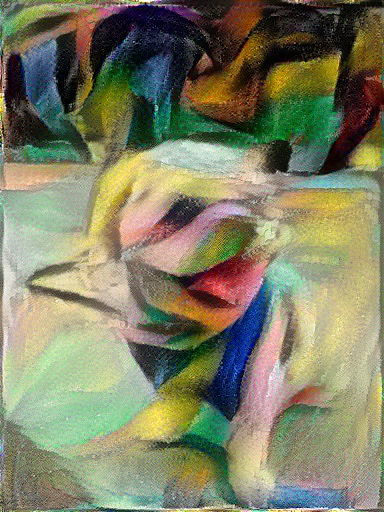

Epoch: 9 | ====================================================================================================

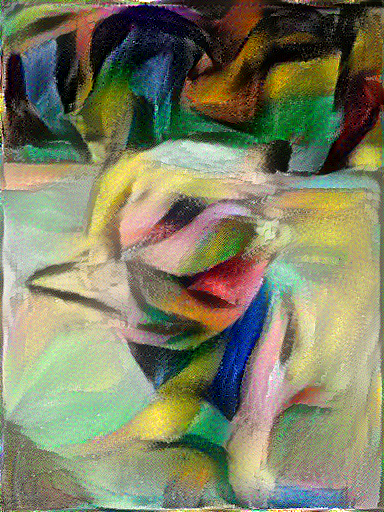

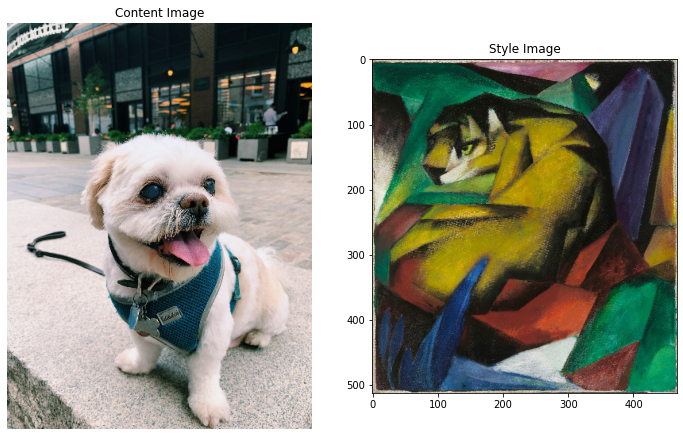

In [34]:
train(image, 10)

In [0]:
display.display(tensor_to_image(image))